In [1]:
# Importamos las principales librerías de python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Cargamos los datos
empleo_nacional = pd.read_excel('input/Data_Proyeccion_Temporal.xlsx', sheet_name='Empleo nacional')
empleo_nacional = empleo_nacional.iloc[:,0:5]
print(empleo_nacional.info())
empleo_nacional

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   año     2057 non-null   int64  
 1   rama    2057 non-null   object 
 2   rdpto   2057 non-null   object 
 3   empleo  2057 non-null   float64
 4   pbi     2057 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 80.5+ KB
None


,año,rama,rdpto,empleo,pbi
0,2007,Perú,Perú,14197152.0,612883137
1,2007,Extractiva,Amazonas,137960.0,727102
2,2007,Manufactura,Amazonas,10745.0,116522
3,2007,Construccion,Amazonas,3759.8,130808
4,2007,Comercio,Amazonas,23002.0,198118
...,...,...,...,...,...
2052,2023,Extractiva,Ucayali,79245.0,764076
2053,2023,Manufactura,Ucayali,19410.0,586592
2054,2023,Construccion,Ucayali,18176.0,380494
2055,2023,Comercio,Ucayali,71490.0,824377


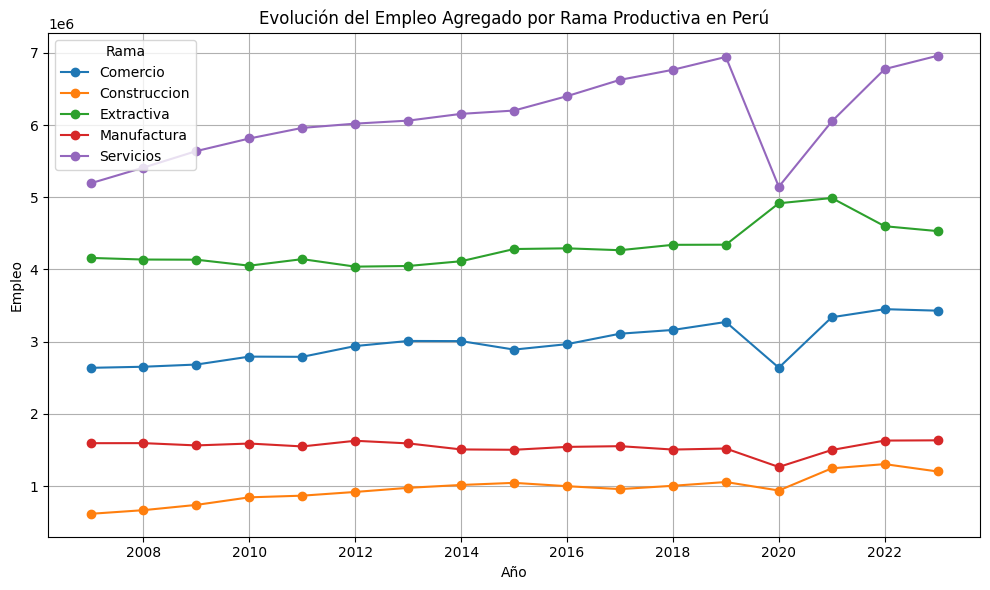

In [3]:
df_sin_peru = empleo_nacional[empleo_nacional['rdpto'] != 'Perú']
df_agregado = df_sin_peru.groupby(['año', 'rama'])['empleo'].sum().reset_index()
ramas = df_agregado['rama'].unique()

plt.figure(figsize=(10, 6))
for rama in ramas:
    df_rama = df_agregado[df_agregado['rama'] == rama]
    plt.plot(df_rama['año'], df_rama['empleo'], marker='o', linestyle='-', label=rama)

# Añadir título y etiquetas
plt.title('Evolución del Empleo Agregado por Rama Productiva en Perú')
plt.xlabel('Año')
plt.ylabel('Empleo')
plt.legend(title='Rama')
plt.grid(True)
plt.tight_layout()
plt.show()

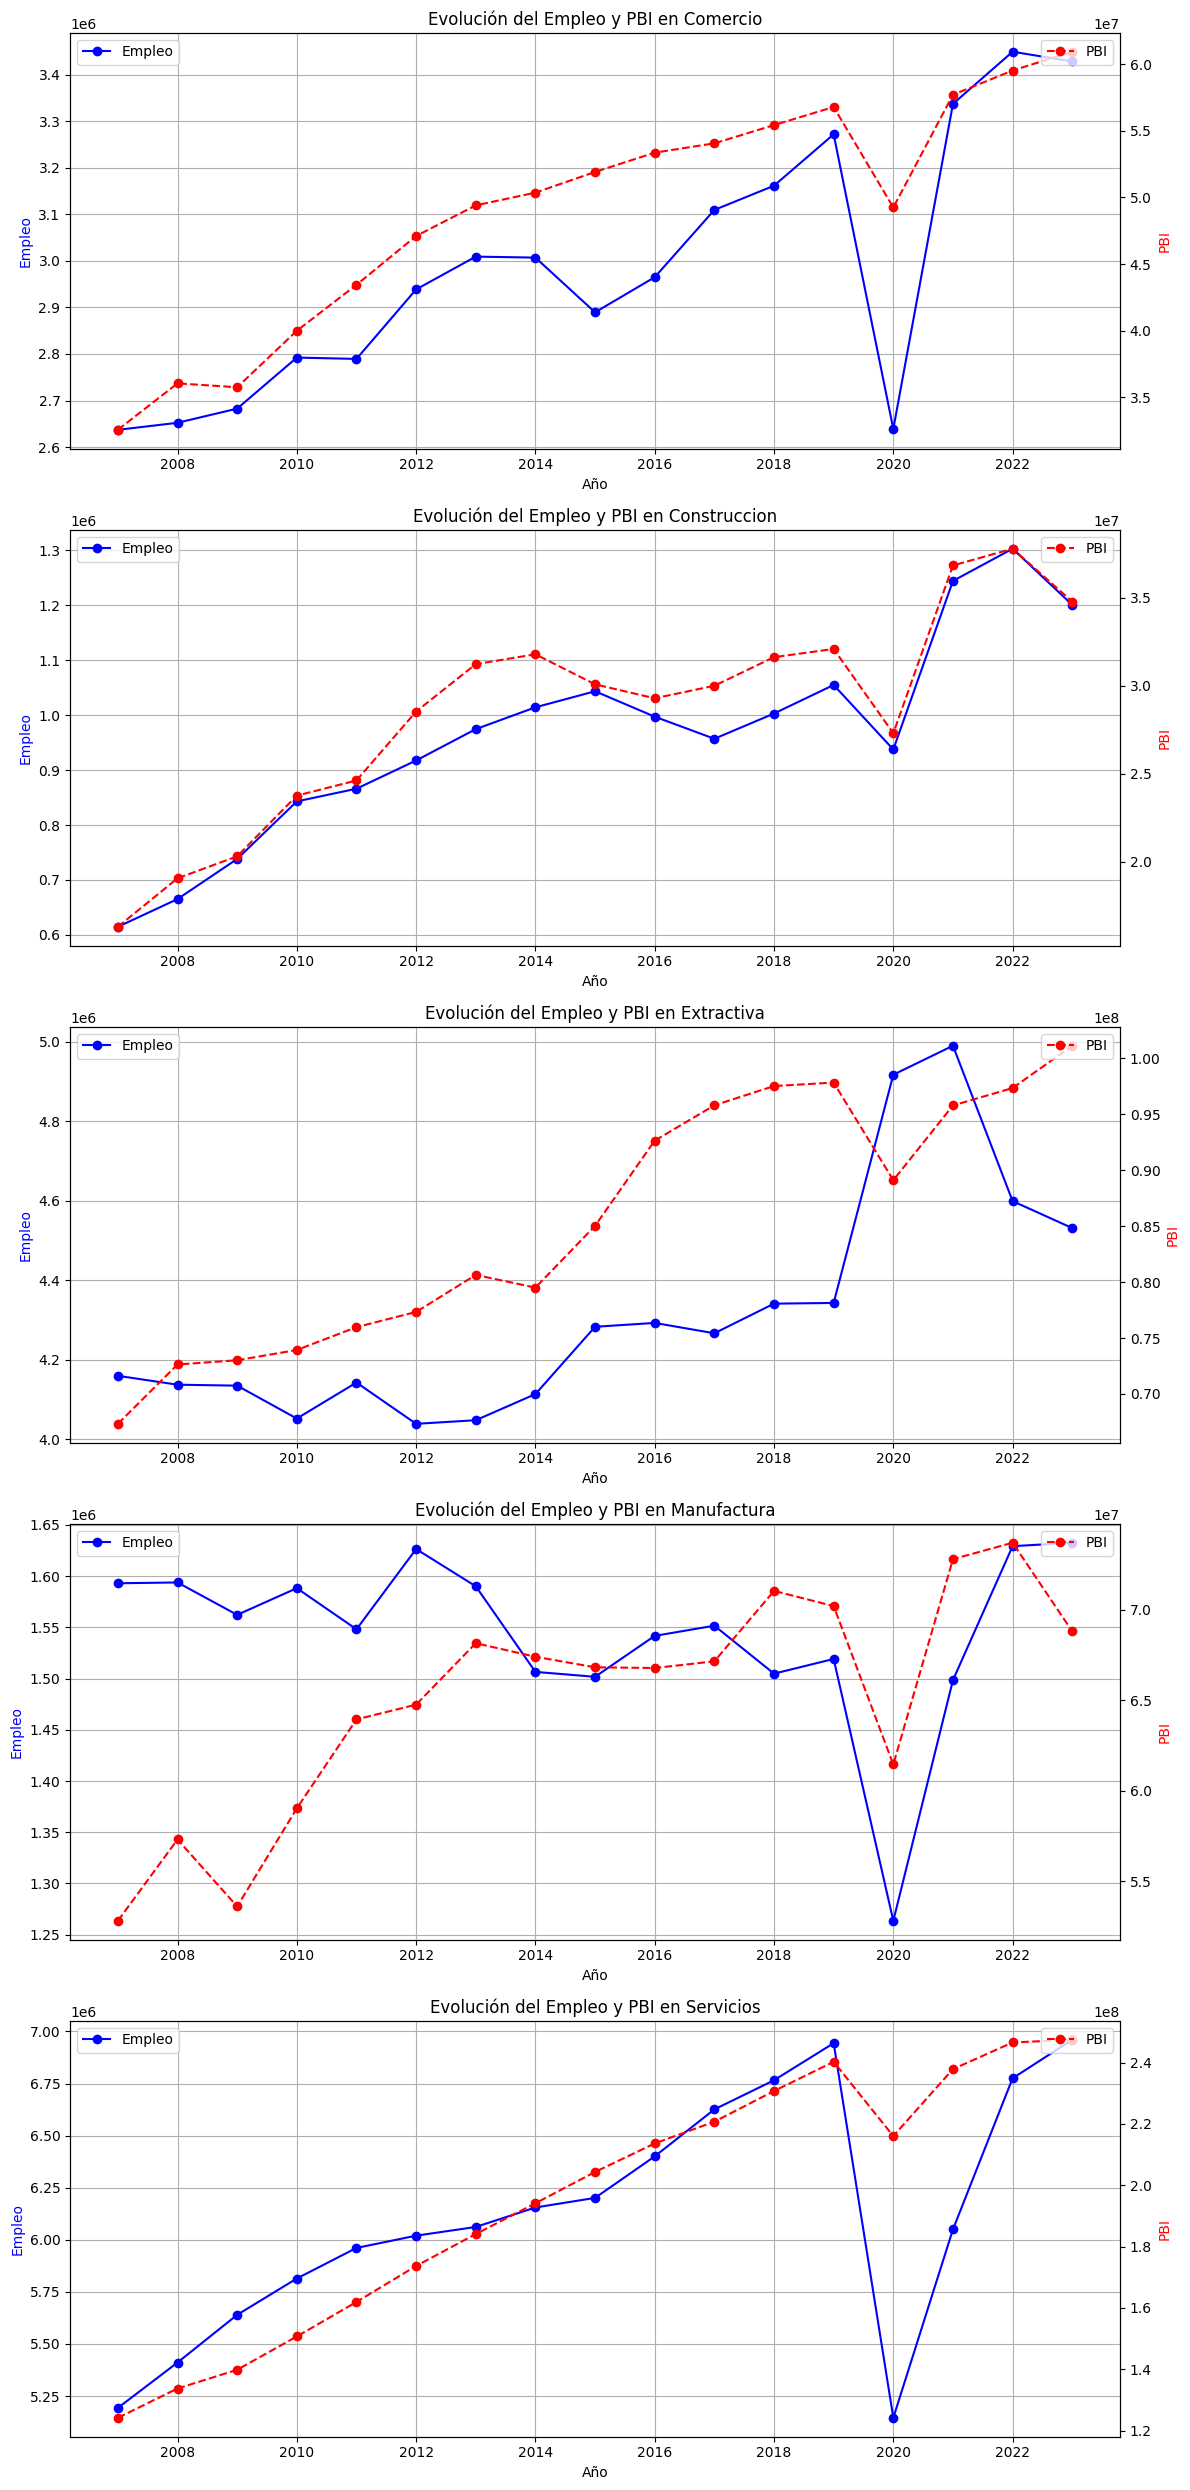

In [4]:
# Agrupar los datos por año y rama, sumando el empleo y el PBI
df_agregado = df_sin_peru.groupby(['año', 'rama'])[['empleo', 'pbi']].sum().reset_index()
ramas = df_agregado['rama'].unique()

fig, axes = plt.subplots(nrows=len(ramas), ncols=1, figsize=(12, 5 * len(ramas)))
if len(ramas) == 1:
    axes = [axes]

for ax, rama in zip(axes, ramas):
    df_rama = df_agregado[df_agregado['rama'] == rama]
    
    # Graficar la evolución del empleo
    ax.plot(df_rama['año'], df_rama['empleo'], marker='o', linestyle='-', color='b', label='Empleo')
    
    # Crear un segundo eje y para el PBI
    ax2 = ax.twinx()
    ax2.plot(df_rama['año'], df_rama['pbi'], marker='o', linestyle='--', color='r', label='PBI')
    
    # Añadir títulos y etiquetas
    ax.set_title(f'Evolución del Empleo y PBI en {rama}')
    ax.set_xlabel('Año')
    ax.set_ylabel('Empleo', color='b')
    ax2.set_ylabel('PBI', color='r')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid(True)
plt.tight_layout()
plt.show()

# Panel OLS models

Here a `MultiIndex DataFrame` is used to hold the data in a format that can be understood as a panel. Before setting the index, a year Categorical is created which facilitated making dummies.

In [5]:
data = df_sin_peru[(df_sin_peru['rama'] == 'Servicios') & (df_sin_peru['año'] <= 2022)].copy()
año = pd.Categorical(data['año'])
data = data.set_index(["rdpto", "año"])
data['log_empleo'] = np.log(data['empleo'])
data['log_pbi']    = np.log(data['pbi'])
data["año"] = año
data.drop(columns=['rama', 'empleo', 'pbi'], inplace=True)
data

,,log_empleo,log_pbi,año
rdpto,año,,,
Amazonas,2007,10.601597,13.315006,2007
Áncash,2007,11.983510,14.984286,2007
Apurímac,2007,10.673040,13.458298,2007
Arequipa,2007,12.465070,15.457063,2007
Ayacucho,2007,11.155965,13.956623,2007
...,...,...,...,...
Puno,2022,12.215022,15.346930,2022
San Martín,2022,11.833210,14.845561,2022
Tacna,2022,11.379154,14.739697,2022


## 1) Basic regression on panel data

`PooledOLS` is just plain OLS that understands that various panel data structures. It is useful as a base model. Here the log employment is modeled using all of the variables and time dummies.

In [6]:
import statsmodels.api as sm
from linearmodels.panel import PooledOLS

exog_vars = ["log_pbi"]
exog = sm.add_constant(data[exog_vars])
mod = PooledOLS(data['log_empleo'], exog)
pooled_res = mod.fit(cov_type="robust")
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:             log_empleo   R-squared:                        0.9240
Estimator:                  PooledOLS   R-squared (Between):              0.9457
No. Observations:                 384   R-squared (Within):              -0.7652
Date:                Mon, Sep 16 2024   R-squared (Overall):              0.9240
Time:                        12:37:48   Log-likelihood                   -34.346
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4644.7
Entities:                          24   P-value                           0.0000
Avg Obs:                       16.000   Distribution:                   F(1,382)
Min Obs:                       16.000                                           
Max Obs:                       16.000   F-statistic (robust):             8311.9
                            

## 2) Random effects

The random effects model is virtually identical to the pooled OLS model except that is accounts for the structure of the model and so is more efficient. Random effects uses a quasi-demeaning strategy which subtracts the time average of the within entity values to account for the common shock.

In [7]:
from linearmodels.panel import RandomEffects

mod = RandomEffects(data['log_empleo'], exog)
re_res = mod.fit(cov_type="robust")
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:             log_empleo   R-squared:                        0.4782
Estimator:              RandomEffects   R-squared (Between):              0.6856
No. Observations:                 384   R-squared (Within):               0.3297
Date:                Mon, Sep 16 2024   R-squared (Overall):              0.6811
Time:                        12:37:48   Log-likelihood                    330.59
Cov. Estimator:                Robust                                           
                                        F-statistic:                      350.11
Entities:                          24   P-value                           0.0000
Avg Obs:                       16.000   Distribution:                   F(1,382)
Min Obs:                       16.000                                           
Max Obs:                       16.000   F-statistic (robust):             362.40
                            

## 3) The between estimator

The between estimator is an alternative, usually less efficient estimator, can can be used to estimate model parameters. It is particular simple since it first computes the time averages of $y$ and $x$ and then runs a simple regression using these averages.

The year dummies are dropped since the averaging removes differences due to the year. These results are broadly similar to the previous models.

In [8]:
from linearmodels.panel import BetweenOLS

mod = BetweenOLS(data['log_empleo'], exog)
be_res = mod.fit(cov_type="robust")
print(be_res)

                         BetweenOLS Estimation Summary                          
Dep. Variable:             log_empleo   R-squared:                        0.9463
Estimator:                 BetweenOLS   R-squared (Between):              0.9463
No. Observations:                  24   R-squared (Within):              -0.8584
Date:                Mon, Sep 16 2024   R-squared (Overall):              0.9234
Time:                        12:37:48   Log-likelihood                    2.1726
Cov. Estimator:                Robust                                           
                                        F-statistic:                      387.66
Entities:                          24   P-value                           0.0000
Avg Obs:                       16.000   Distribution:                    F(1,22)
Min Obs:                       16.000                                           
Max Obs:                       16.000   F-statistic (robust):             690.38
                            

## 4) Including fixed effects

Entity effects are included by setting `entity_effects=True`. This is equivalent to including dummies for each entity. In this panel, this would add 545 dummy variables and estimation of the model would be considerably slower. `PanelOLS` does not actually use dummy variables and instead uses group-wise demeaning to achieve the same effect.

Time-invariant variables cannot be included when using entity effects since, once demeaned, these will all be 0.

In [9]:
from linearmodels.panel import PanelOLS

mod = PanelOLS(data['log_empleo'], exog, entity_effects=True)
fe_res = mod.fit(cov_type="robust")
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:             log_empleo   R-squared:                        0.3725
Estimator:                   PanelOLS   R-squared (Between):              0.5525
No. Observations:                 384   R-squared (Within):               0.3725
Date:                Mon, Sep 16 2024   R-squared (Overall):              0.5502
Time:                        12:37:48   Log-likelihood                    398.85
Cov. Estimator:                Robust                                           
                                        F-statistic:                      213.11
Entities:                          24   P-value                           0.0000
Avg Obs:                       16.000   Distribution:                   F(1,359)
Min Obs:                       16.000                                           
Max Obs:                       16.000   F-statistic (robust):             217.60
                            

## 5) Time Effects

Time effect can be added using `time_effects=True`. Here the time dummies are removed. Note that the core coefficients are identical. The only change is in the test statistic for poolability since not the “effects” include both entity and time, whereas before only entity were included.

In [10]:
mod = PanelOLS(data['log_empleo'], exog, entity_effects=True, time_effects=True)
fe_te_res = mod.fit(cov_type="robust")
print(fe_te_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:             log_empleo   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):              0.0604
No. Observations:                 384   R-squared (Within):               0.0650
Date:                Mon, Sep 16 2024   R-squared (Overall):              0.0605
Time:                        12:37:48   Log-likelihood                    548.94
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0868
Entities:                          24   P-value                           0.7685
Avg Obs:                       16.000   Distribution:                   F(1,344)
Min Obs:                       16.000                                           
Max Obs:                       16.000   F-statistic (robust):             0.0690
                            

## Comparing models

In [11]:
from linearmodels.panel import compare

print(compare({"RE": re_res, "FE": fe_res, "FE-Time":fe_te_res, "Pooled": pooled_res, "BE": be_res}))

                                           Model Comparison                                          
                                       RE             FE        FE-Time         Pooled             BE
-----------------------------------------------------------------------------------------------------
Dep. Variable                  log_empleo     log_empleo     log_empleo     log_empleo     log_empleo
Estimator                   RandomEffects       PanelOLS       PanelOLS      PooledOLS     BetweenOLS
No. Observations                      384            384            384            384             24
Cov. Est.                          Robust         Robust         Robust         Robust         Robust
R-squared                          0.4782         0.3725         0.0003         0.9240         0.9463
R-Squared (Within)                 0.3297         0.3725         0.0650        -0.7652        -0.8584
R-Squared (Between)                0.6856         0.5525         0.0604         0.

In [12]:
fe_res.cov

,const,log_pbi
const,0.097859,-0.006613
log_pbi,-0.006613,0.000447


In [13]:
# Hausman test for fixed versus random effects model
# null hypothesis: random effects model
psi = fe_res.cov.iloc[1:,1:] - re_res.cov.iloc[1:,1:]
diff = fe_res.params[1:] - re_res.params[1:]
W = diff.dot(np.linalg.inv(psi)).dot(diff)
dof = re_res.params.size -1
pvalue = stats.chi2(dof).sf(W)
print("Hausman Test: chisq = {0}, df = {1}, p-value = {2}".format(W, dof, pvalue))

Hausman Test: chisq = -327.5504245342892, df = 1, p-value = 1.0
